SYSEN 5888 Spring 2026

Jonathan Lloyd

Homework 1, Question 1


Goal: Build and train an artificial neural network for a binary classification task. 

Tools: Pytorch

Data: The input data and their corresponding binary labels are provided in the data file, hw1data.dat
The input data contains 1000 two-dimensional data points that lie within a square of area one. The input data and labels should be loaded by reading the data file using any choice of library. Please note that for binary classification, the -1/1 labels need to be converted into 0/1 labels.

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from IPython.display import display
from pathlib import Path

# Import data file
hw1data = np.loadtxt("../HW_01_ANN/hw1data.dat")

# Quick look at the data
print("Shape:", hw1data.shape)
print("First 5 rows:")
print(hw1data[:5])

# Convert data labels -1/1 to 0/1
# if data label in column 3 (index 2) is -1, reset to 0
hw1data[:, 2] = np.where(hw1data[:, 2] == -1, 0, hw1data[:, 2])
print("First 5 rows relabeled:")
print(hw1data[:5])

# Split off third column as data labels 
# Convert to PyTorch tensors
features = torch.tensor(hw1data[:, :2], dtype=torch.float64)
labels = torch.tensor(hw1data[:, 2], dtype=torch.int64)
# Check
# print(features[:,:2])
# print(labels)

# Define dataset and data. Same data for training and test, but load without shuffling for test
traintest_dataset = TensorDataset(features, labels)
train_dataloader = DataLoader(traintest_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(traintest_dataset, batch_size=32, shuffle=False)

Shape: (1000, 3)
First 5 rows:
[[ 0.73662472  0.50544176 -1.        ]
 [ 0.71066494  0.56503663 -1.        ]
 [ 0.10533493  0.06889585  1.        ]
 [ 0.95860447  0.16390308  1.        ]
 [ 0.42369288  0.51051878 -1.        ]]
First 5 rows relabeled:
[[0.73662472 0.50544176 0.        ]
 [0.71066494 0.56503663 0.        ]
 [0.10533493 0.06889585 1.        ]
 [0.95860447 0.16390308 1.        ]
 [0.42369288 0.51051878 0.        ]]


Architecture: Define a Sequential model, wherein the layers are stacked sequentially and each layer has exactly one input tensor and one output tensor. Please build an artificial neural network by adding the following layers to the Sequential model using the configuration below.
- Input - Shape 2
- Dense - Units 5
- Dense - Units 1 - Activation Sigmoid

The initial random weights of layers can be defined by specifying weight and bias initializers. For each of the above layers, initialize the kernel weights from a Xavier/Glorot uniform distribution and set the random seed to 99. Additionally, initialize the bias vector as a zero vector. The activation function defines the node output given a set of inputs. An appropriate choice of activation function is required to allow the artificial neural network to learn a non-linear pattern. The activation functions for the first dense layer can be chosen from some of the commonly used activation functions like Rectified Linear Unit (ReLU), Hyperbolic Tangent (tanh), and Sigmoid.

In [2]:
# Define Model Class
# Architecture: Input(2) -> Dense(5) -> [activation] -> Dense(1) -> Sigmoid -> Output
class Q1SequentialModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, input_activations='relu'): # Default ReLU
        super(Q1SequentialModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        activations_options = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid()}
        self.input_act = activations_options[input_activations]
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.input_act(x)
        x = self.fc2(x)
        x = self.output_act(x)
        return x

    def _init_weights_biases(self):
        # Initialize kernel weights with Xavier/Glorot uniform, Seed=99
        torch.manual_seed(99)
        for layer in [self.fc1, self.fc2]:
            nn.init.xavier_uniform_(layer.weight) 
            # Initialize biases with zeros
            nn.init.zeros_(layer.bias) 


Training: The model is compiled by specifying the optimizer, the loss function and metrics to be recorded at each step of the training process. For binary classification, it is a common practice to use binary cross-entropy as loss function. Popular deep learning libraries provide support for several optimization algorithms. Some of them are Stochastic gradient descent (SGD), RMSprop, ADAM. Please choose accuracy as a metric during model compilation. Finally, train the artificial neural network by fitting the input data and labels with each of the aforementioned optimizers and their respective configuration as given in the table below. The neural network should be trained until convergence is achieved.

In [3]:
# Useful across models
activation_function_selector = ['relu', 'tanh', 'sigmoid']

# Data storage
results_dataframe = pd.DataFrame(columns=[
    'Optimizer', 'Activation Function', 'Learning Rate', 'Momentum', 'Epsilon',
    'Beta1', 'Beta2', 'Required Epochs', 'Training Accuracy (%)', 'Prediction for [0.8, 0.2]'
])

def train(model, train_loader, criterion, optimizer, max_epochs, patience=1000, min_delta=0.001):
    # Train model until convergence with min-delta early stopping. Returns (loss_curve, epochs_required).
    model.train()
    loss_curve = []
    epochs_without_improvement = 0
    best_loss = float('inf')

    for epoch in range(max_epochs):
        epoch_loss = 0.0
        n_batches = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x.float())
            batch_y_float = batch_y.float().unsqueeze(1)
            loss = criterion(outputs, batch_y_float)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        loss_curve.append(avg_loss)

        # Min-delta early stopping: only count as improvement if loss decreased by at least min_delta
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            return loss_curve, epoch + 1

    return loss_curve, max_epochs

def evaluate(model, dataloader):
    # Compute training accuracy (%). Returns accuracy percentage.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x.float())
            preds = (outputs >= 0.5).long().squeeze()
            total += batch_y.size(0)
            correct += (preds == batch_y).sum().item()
    return 100.0 * correct / total

def predict(model, x, threshold=0.5):
    # Predict class (0 or 1) for input x. x should be shape (1, 2) or (2,).
    model.eval()
    with torch.no_grad():
        if isinstance(x, (list, tuple)):
            x = torch.tensor([x], dtype=torch.float32)
        elif x.dim() == 1:
            x = x.unsqueeze(0)
        outputs = model(x.float())
        return 1 if outputs.item() >= threshold else 0

def plot_loss(curve, act, opt, lr=None, mom=None, eps=None, beta1=None, beta2=None):
    # Plot and save loss curve. Only optimizer-relevant params are used in title/filename.
    output_dir = "Plot JPGs"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    plt.figure()
    plt.plot(curve)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if opt == "SGD":
        plt.title(f"Binary Cross Entropy Loss Curve. Activation {act}, Optimizer {opt}, Learning Rate {lr}, Momentum {mom}")
        filename = f"{output_dir}/LossCurve_{opt}_{act}_LR{lr}_Momentum{mom}.jpg"
    elif opt == "RMSprop":
        plt.title(f"Binary Cross Entropy Loss Curve. Activation {act}, Optimizer {opt}, Learning Rate {lr}, Epsilon {eps}")
        filename = f"{output_dir}/LossCurve_{opt}_{act}_LR{lr}_Eps{eps}.jpg"
    elif opt == "ADAM":
        plt.title(f"Binary Cross Entropy Loss Curve. Activation {act}, Optimizer {opt}, β_1 {beta1}, β_2 {beta2}")
        filename = f"{output_dir}/LossCurve_{opt}_{act}_B1{beta1}_B2{beta2}.jpg"
    else:
        plt.title(f"Binary Cross Entropy Loss Curve. Activation {act}, Optimizer {opt}")
        filename = f"{output_dir}/LossCurve_{opt}_{act}.jpg"
        
    plt.savefig(filename)
    plt.close()

def run_experiment(train_loader, act, opt_name, lr=None, momentum=None, eps=None, beta1=None, beta2=None, max_epochs=20000):
    # Run one experiment: create model, train, evaluate, predict, plot. Return dataframe row
  
    model = Q1SequentialModel(2, 5, 1, act)
    model._init_weights_biases()
    loss_function = nn.BCELoss()  # Binary cross-entropy for sigmoid output

    if opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif opt_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)
    elif opt_name == "ADAM":
        optimizer = optim.Adam(model.parameters(), lr=lr or 0.001, betas=(beta1, beta2))
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

    loss_curve, epochs = train(model, train_loader, loss_function, optimizer, max_epochs)
    accuracy = evaluate(model, train_loader)
    pred = predict(model, [0.8, 0.2])

    plot_loss(loss_curve, act, opt_name, lr=lr, mom=momentum, eps=eps, beta1=beta1, beta2=beta2)

    row = {
        'Optimizer': opt_name,
        'Activation Function': act.capitalize(),
        'Learning Rate': lr,
        'Momentum': momentum,
        'Epsilon': eps,
        'Beta1': beta1,
        'Beta2': beta2,
        'Required Epochs': epochs,
        'Training Accuracy (%)': round(accuracy, 2),
        'Prediction for [0.8, 0.2]': pred
    }
    
    return row
    

Deliverables: Please report the training accuracy after the training process is carried out for *every combination* of activation function and optimizer.
Plot the loss curves to determine the number of epochs required to achieve convergence.
Report the hyperparameter tuning step.
Predict and report the binary classification results for the data point [0.8, 0.2] with the trained artificial neural network.
Discuss the influence of particular parameters on different optimizers.
It is recommended that the final results be reported in a tabular format as shown below. Please also make sure to submit your working code files along with the final results.

<table>
<thead><tr><th>Optimizer</th><th>Activation function</th><th>Required epochs</th><th>Training accuracy (%)</th><th>Prediction for [0.8, 0.2]</th></tr></thead>
<tbody>
<tr><td rowspan="3">SGD<br>(Learning rate = 0.01, Momentum = [0.0, 0.1, 0.5, 0.9], discuss the impact of momentum values on the convergence behavior of the SGD optimizer)</td><td>ReLU</td><td></td><td></td><td></td></tr>
<tr><td>Tanh</td><td></td><td></td><td></td></tr>
<tr><td>Sigmoid</td><td></td><td></td><td></td></tr>
<tr><td rowspan="3">RMSprop<br>(Learning rate = [0.0001, 0.001, 0.01], discuss the effect of learning rates on learning curves, Epsilon = 10^-6)</td><td>ReLU</td><td></td><td></td><td></td></tr>
<tr><td>Tanh</td><td></td><td></td><td></td></tr>
<tr><td>Sigmoid</td><td></td><td></td><td></td></tr>
<tr><td rowspan="3">ADAM<br>(β₁=[0.85, 0.9], β₂=[0.95, 0.99], discuss the functions of the parameters β₁ and β₂)</td><td>ReLU</td><td></td><td></td><td></td></tr>
<tr><td>Tanh</td><td></td><td></td><td></td></tr>
<tr><td>Sigmoid</td><td></td><td></td><td></td></tr>
</tbody>
</table>


In [4]:
# Test training sequence
"""
sgdlr = 0.01
sgdmom = 0.0
max_epochs = 20000

model_run = run_experiment(train_dataloader, activation_function_selector[0], "SGD", sgdlr, sgdmom, max_epochs=max_epochs)
test_df = pd.DataFrame(columns=[
    'Optimizer', 'Activation Function', 'Learning Rate', 'Momentum', 'Epsilon',
    'Beta1', 'Beta2', 'Required Epochs', 'Training Accuracy (%)', 'Prediction for [0.8, 0.2]'
])
test_df = pd.concat([test_df, pd.DataFrame([model_run])], ignore_index=True)
print(test_df) 
"""

'\nsgdlr = 0.01\nsgdmom = 0.0\nmax_epochs = 20000\n\nmodel_run = run_experiment(train_dataloader, activation_function_selector[0], "SGD", sgdlr, sgdmom, max_epochs=max_epochs)\ntest_df = pd.DataFrame(columns=[\n    \'Optimizer\', \'Activation Function\', \'Learning Rate\', \'Momentum\', \'Epsilon\',\n    \'Beta1\', \'Beta2\', \'Required Epochs\', \'Training Accuracy (%)\', \'Prediction for [0.8, 0.2]\'\n])\ntest_df = pd.concat([test_df, pd.DataFrame([model_run])], ignore_index=True)\nprint(test_df) \n'

In [5]:
# SGD Optimizer
# Learning rate = 0.01
# Momentum = [0.0, 0.1, 0.5, 0.9]
# Activation function = [ReLU, Tanh, Sigmoid]
# For each run, report required epochs, training accuracy, and prediction for [0.8, 0.2]

# Define hyperparameters, Initialize results dataframe
sgd_learning_rate = 0.01
sgd_momentum_selector = [0.0, 0.1, 0.5, 0.9]
max_epochs = 20000
SGD_df = pd.DataFrame(columns=[
    'Optimizer', 'Activation Function', 'Learning Rate', 'Momentum', 'Epsilon',
    'Beta1', 'Beta2', 'Required Epochs', 'Training Accuracy (%)', 'Prediction for [0.8, 0.2]'
])
test_counter = 0

# Training Loops
for act in activation_function_selector:
    for mom in sgd_momentum_selector:
        model_run = run_experiment(train_dataloader, act, "SGD", sgd_learning_rate, mom, max_epochs=max_epochs)
        SGD_df = pd.concat([SGD_df, pd.DataFrame([model_run])], ignore_index=True) 
        
        # test prints after each run
        test_counter=test_counter+1
        print(f"TEST COUNTER {test_counter} OF 12")
        print(SGD_df.tail(1))
        

print(SGD_df)

TEST COUNTER 1 OF 12
  Optimizer Activation Function Learning Rate Momentum Epsilon Beta1 Beta2  \
0       SGD                Relu          0.01      0.0    None  None  None   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
0           11632                  97.1                         1  
TEST COUNTER 2 OF 12
  Optimizer Activation Function Learning Rate Momentum Epsilon Beta1 Beta2  \
1       SGD                Relu          0.01      0.1    None  None  None   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
1           11632                  97.1                         1  
TEST COUNTER 3 OF 12
  Optimizer Activation Function Learning Rate Momentum Epsilon Beta1 Beta2  \
2       SGD                Relu          0.01      0.5    None  None  None   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
2            7292                  97.0                         1  
TEST COUNTER 4 OF 12
  Optimizer Activation Function Learn

In [6]:
# RMSprop Optimizer 
# Learning rates (Learning rate = [0.0001, 0.001, 0.01]
# Epsilon = 10^-6
# Activation function = [ReLU, Tanh, Sigmoid]
# For each run, report required epochs, training accuracy, and prediction for [0.8, 0.2]

# Define hyperparameters, Initialize results dataframe
rms_learning_rate_selector = [0.0001, 0.001, 0.01]
epsilon = 1e-6 
max_epochs = 20000
RMSprop_df = pd.DataFrame(columns=[
    'Optimizer', 'Activation Function', 'Learning Rate', 'Momentum', 'Epsilon',
    'Beta1', 'Beta2', 'Required Epochs', 'Training Accuracy (%)', 'Prediction for [0.8, 0.2]'
])
test_counter = 0

# Training Loops
for act in activation_function_selector:
    for lr in rms_learning_rate_selector:
        model_run = run_experiment(train_dataloader, act, "RMSprop", lr=lr, eps=epsilon, max_epochs=max_epochs)
        RMSprop_df = pd.concat([RMSprop_df, pd.DataFrame([model_run])], ignore_index=True)
        
        test_counter = test_counter + 1
        print(f"TEST COUNTER {test_counter} OF 9")
        print(RMSprop_df.tail(1))

print(RMSprop_df)



TEST COUNTER 1 OF 9
  Optimizer Activation Function Learning Rate Momentum   Epsilon Beta1 Beta2  \
0   RMSprop                Relu        0.0001     None  0.000001  None  None   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
0           14963                  80.1                         1  
TEST COUNTER 2 OF 9
  Optimizer Activation Function Learning Rate Momentum   Epsilon Beta1 Beta2  \
1   RMSprop                Relu         0.001     None  0.000001  None  None   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
1           14204                  96.5                         1  
TEST COUNTER 3 OF 9
  Optimizer Activation Function Learning Rate Momentum   Epsilon Beta1 Beta2  \
2   RMSprop                Relu          0.01     None  0.000001  None  None   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
2            4144                  97.0                         1  
TEST COUNTER 4 OF 9
  Optimizer Activation Functi

In [7]:
# ADAM Optimizer
# beta_1 = [0.85, 0.9] 
# beta_2 = [0.95, 0.99] 
# Activation function = [ReLU, Tanh, Sigmoid]
# For each run, report required epochs, training accuracy, and prediction for [0.8, 0.2]

# Define hyperparameters, Initialize results dataframe
beta_1 = [0.85, 0.9]
beta_2 = [0.95, 0.99]
max_epochs = 20000
ADAM_df = pd.DataFrame(columns=[
    'Optimizer', 'Activation Function', 'Learning Rate', 'Momentum', 'Epsilon',
    'Beta1', 'Beta2', 'Required Epochs', 'Training Accuracy (%)', 'Prediction for [0.8, 0.2]'
])
test_counter = 0

# Training Loops
for act in activation_function_selector:
    for b1 in beta_1:
        for b2 in beta_2:
            model_run = run_experiment(train_dataloader, act, "ADAM", beta1=b1, beta2=b2, max_epochs=max_epochs)
            ADAM_df = pd.concat([ADAM_df, pd.DataFrame([model_run])], ignore_index=True)
            
            test_counter = test_counter + 1
            print(f"TEST COUNTER {test_counter} OF 12")
            print(ADAM_df.tail(1))

print(ADAM_df)



TEST COUNTER 1 OF 12
  Optimizer Activation Function Learning Rate Momentum Epsilon Beta1 Beta2  \
0      ADAM                Relu          None     None    None  0.85  0.95   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
0           16621                  96.8                         1  
TEST COUNTER 2 OF 12
  Optimizer Activation Function Learning Rate Momentum Epsilon Beta1 Beta2  \
1      ADAM                Relu          None     None    None  0.85  0.99   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
1           16621                  96.8                         1  
TEST COUNTER 3 OF 12
  Optimizer Activation Function Learning Rate Momentum Epsilon Beta1 Beta2  \
2      ADAM                Relu          None     None    None   0.9  0.95   

  Required Epochs Training Accuracy (%) Prediction for [0.8, 0.2]  
2           15951                  97.0                         1  
TEST COUNTER 4 OF 12
  Optimizer Activation Function Learn

In [8]:
# Predict and Report Results Table
combined_results_df = pd.DataFrame(columns=[
    'Optimizer', 'Activation Function', 'Learning Rate', 'Momentum', 'Epsilon',
    'Beta1', 'Beta2', 'Required Epochs', 'Training Accuracy (%)', 'Prediction for [0.8, 0.2]'
])
combined_results_df = pd.concat([SGD_df, RMSprop_df, ADAM_df], ignore_index=True)

# Display as a clean HTML table (use display() in Jupyter instead of print())
# Run SGD, RMSprop, and ADAM cells first so SGD_df, RMSprop_df, ADAM_df are defined
try:
    display(combined_results_df.style.hide(axis=0).set_properties(
        **{'text-align': 'center', 'border': '1px solid #ddd'}
    ).set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}]))
except NameError as e:
    print(f"Error: {e}. Run the SGD, RMSprop, and ADAM optimizer cells first.")

Optimizer,Activation Function,Learning Rate,Momentum,Epsilon,Beta1,Beta2,Required Epochs,Training Accuracy (%),"Prediction for [0.8, 0.2]"
SGD,Relu,0.010000,0.000000,None,None,None,11632,97.100000,1
SGD,Relu,0.010000,0.100000,None,None,None,11632,97.100000,1
SGD,Relu,0.010000,0.500000,None,None,None,7292,97.000000,1
SGD,Relu,0.010000,0.900000,None,None,None,4148,97.100000,1
SGD,Tanh,0.010000,0.000000,None,None,None,10413,100.000000,1
SGD,Tanh,0.010000,0.100000,None,None,None,9613,100.000000,1
SGD,Tanh,0.010000,0.500000,None,None,None,7274,100.000000,1
SGD,Tanh,0.010000,0.900000,None,None,None,3202,100.000000,1
SGD,Sigmoid,0.010000,0.000000,None,None,None,20000,99.800000,1
SGD,Sigmoid,0.010000,0.100000,None,None,None,20000,99.800000,1


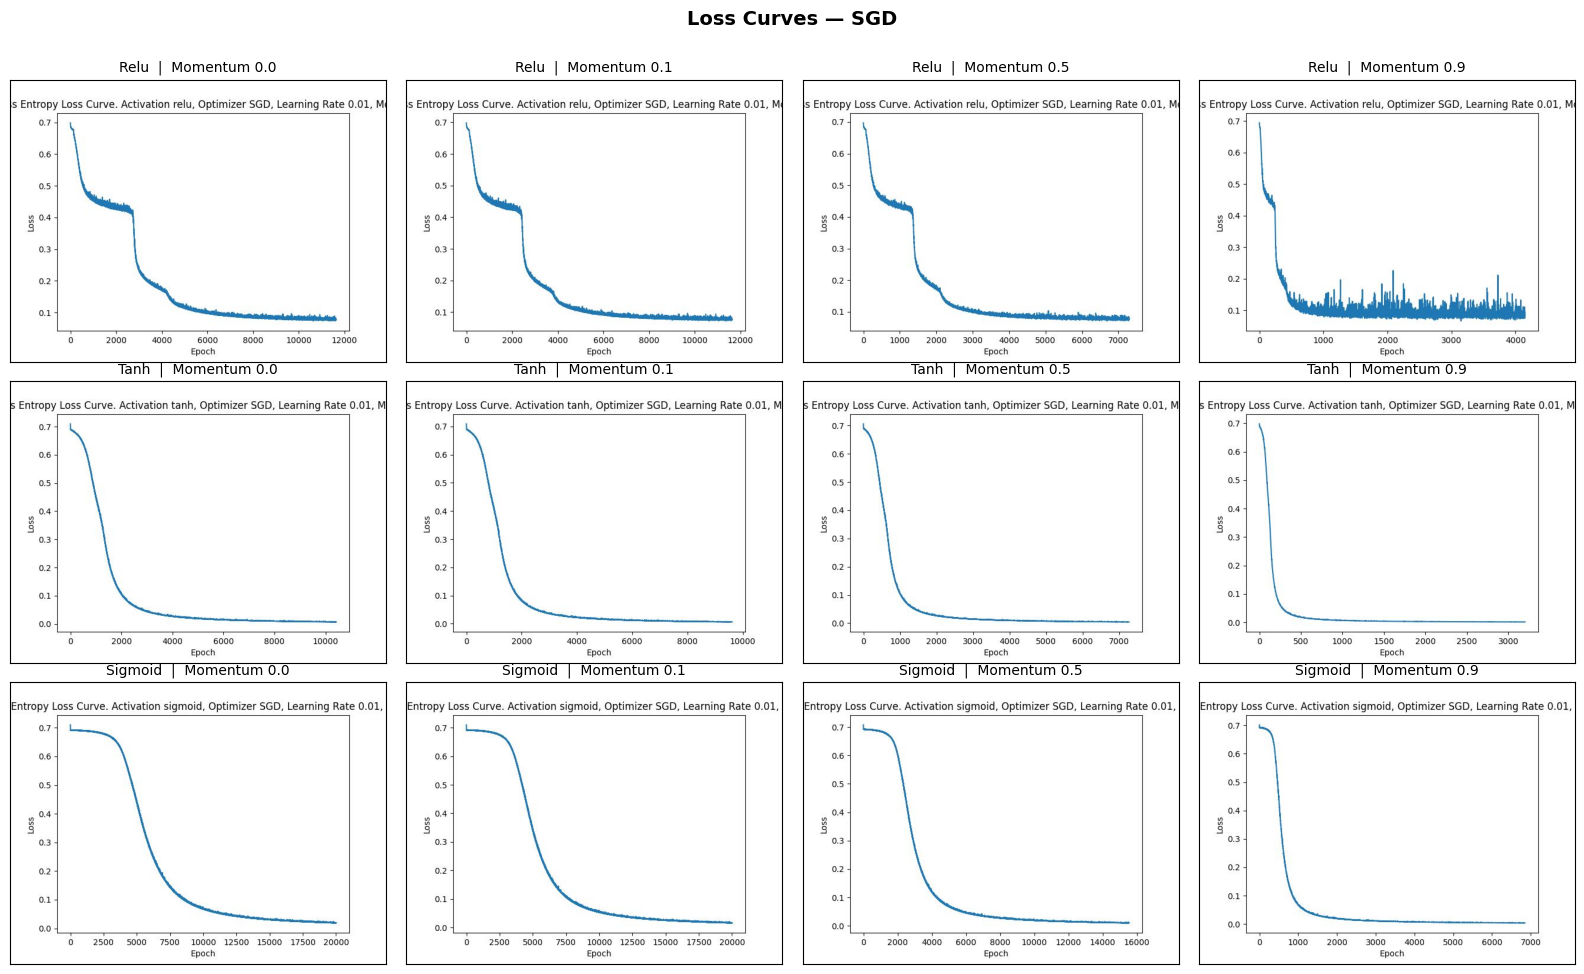

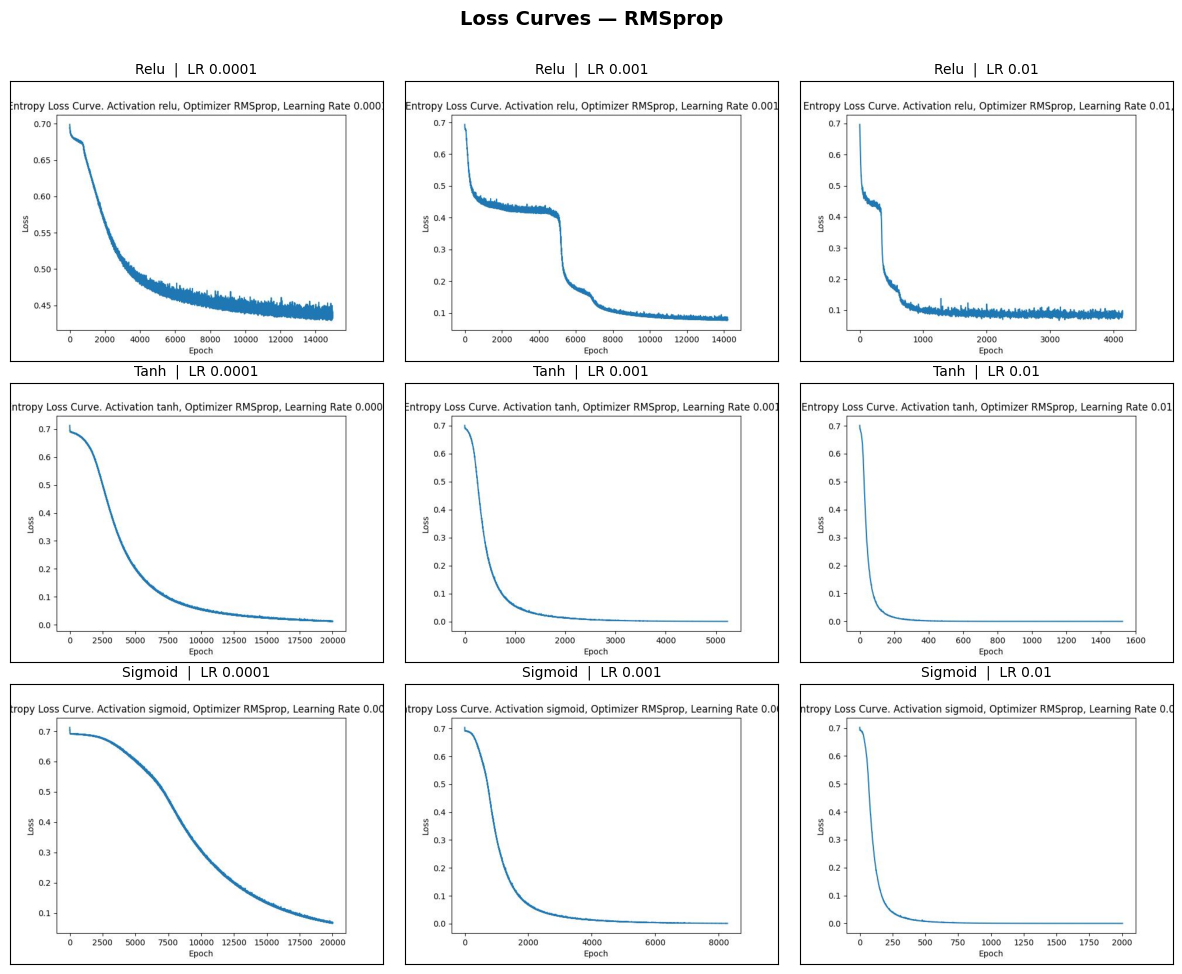

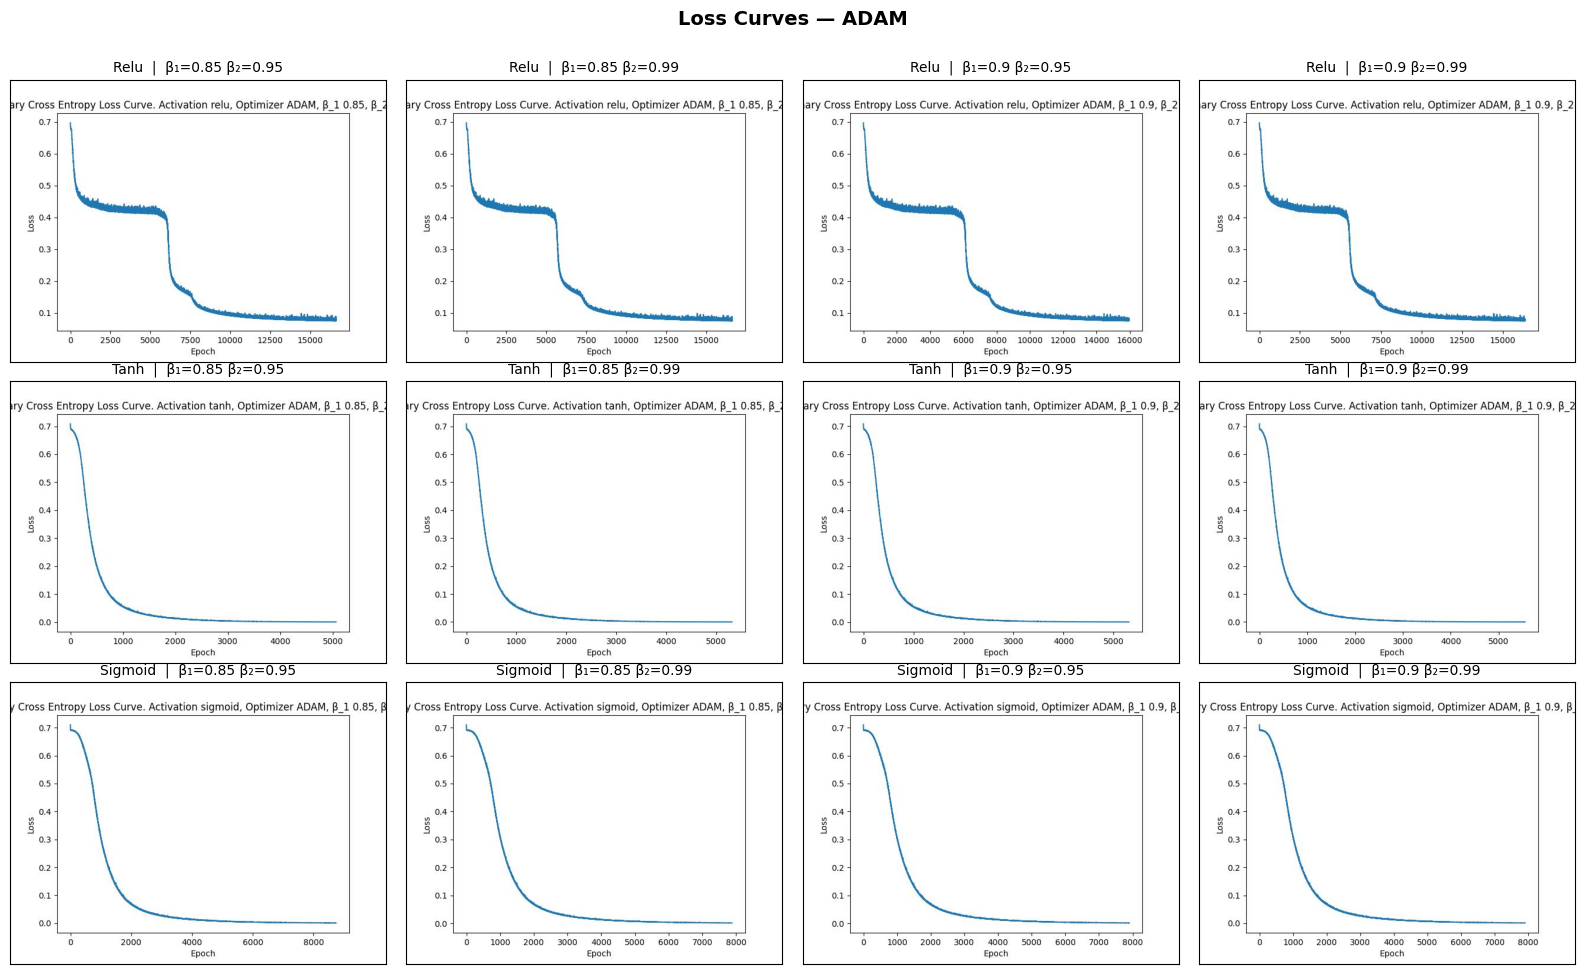

In [9]:
# Print All Loss Curves
# Load every JPG from Plot JPGs folder and display in a grid (grouped by optimizer)

plot_dir = Path("Plot JPGs")
if not plot_dir.exists():
    plot_dir = Path("HW_01_ANN/Plot JPGs")

jpg_files = sorted(plot_dir.glob("*.jpg"))
if not jpg_files:
    print("No JPG files found in Plot JPGs folder. Run the SGD, RMSprop, and ADAM cells first.")
else:
    def parse_file(path):
        """Extract (optimizer, activation, col_key) from filename for grid placement."""
        s = path.stem  # e.g. LossCurve_SGD_relu_LR0.01_Momentum0.0
        parts = s.replace("LossCurve_", "").split("_")
        if len(parts) < 2:
            return None, None, None
        opt, act = parts[0], parts[1]
        col_key = None
        for p in parts[2:]:
            if opt == "SGD" and "Momentum" in p:
                col_key = p.replace("Momentum", "")
                break
            elif opt == "RMSprop" and p.startswith("LR"):
                col_key = p.replace("LR", "")
                break
            elif opt == "ADAM" and (p.startswith("B1") or p.startswith("B2")):
                b1 = next((x.replace("B1", "") for x in parts if x.startswith("B1")), "")
                b2 = next((x.replace("B2", "") for x in parts if x.startswith("B2")), "")
                col_key = (b1, b2) if b1 and b2 else None
                break
        return opt, act, col_key

    groups = {"SGD": {}, "RMSprop": {}, "ADAM": {}}
    for f in jpg_files:
        opt, act, col_key = parse_file(f)
        if opt in groups and col_key is not None:
            groups[opt][(act, col_key)] = f

    layouts = {"SGD": (3, 4), "RMSprop": (3, 3), "ADAM": (3, 4)}
    act_order = ["relu", "tanh", "sigmoid"]
    sgd_cols = ["0.0", "0.1", "0.5", "0.9"]
    rms_cols = ["0.0001", "0.001", "0.01"]
    adam_cols = [("0.85", "0.95"), ("0.85", "0.99"), ("0.9", "0.95"), ("0.9", "0.99")]

    for opt_name, file_map in groups.items():
        if not file_map:
            continue
        nrows, ncols = layouts[opt_name]
        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3.2 * nrows))
        if nrows * ncols == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        col_order = sgd_cols if opt_name == "SGD" else (rms_cols if opt_name == "RMSprop" else adam_cols)
        for row_idx, act in enumerate(act_order):
            for col_idx, ck in enumerate(col_order):
                i = row_idx * len(col_order) + col_idx
                if i >= len(axes):
                    break
                ax = axes[i]
                key = (act, ck)
                if key in file_map:
                    ax.imshow(plt.imread(file_map[key]))
                    if opt_name == "SGD":
                        ax.set_title(f"{act.capitalize()}  |  Momentum {ck}", fontsize=10)
                    elif opt_name == "RMSprop":
                        ax.set_title(f"{act.capitalize()}  |  LR {ck}", fontsize=10)
                    else:
                        ax.set_title(f"{act.capitalize()}  |  β₁={ck[0]} β₂={ck[1]}", fontsize=10)
                ax.set_xticks([])
                ax.set_yticks([])

        fig.suptitle(f"Loss Curves — {opt_name}", fontsize=14, fontweight="bold", y=1.01)
        plt.tight_layout()
        plt.show()

DISCUSSION SECTION

*SGD Discussion:*

Increasing the momentum values led to faster convergence but noisy tails with ReLU activation. Across all the activation functions, increasing momentum had the effect of pulling the first steep training curve to the left, causing a larger and faster leap towards convergence. The tail lengths stayed similar, which ultimately causes faster training (less epochs).

*RMSprop Discussion:*

Intuitively, increasing the learning rates caused convergence timelines to improve by leaps and bounds. ReLU activation shelves were reached faster and overcame faster. Tanh and Sigmoid curves were compressed left with each order of magnitude step. 

*ADAM Discussion:* 

Beta1 controls the direction of the gradient while Beta2 controls the step size scaling. Both function as secondary effects in this classification problem. The effects of Beta2 are most clearly visible in the ReLU runs. Increasing Beta2 makes Adam more conservative, with smoother curves and delayed drops. Beta1 effects are harder to notice. The best comparison may be the first and third ReLU plots - the loss curve coasts slightly longer in the plateaus/shelves before dropping again. 

CLEANER TABLE: 

| Optimizer | Activation Function | Learning Rate | Momentum | Epsilon | Beta1 | Beta2 | Required Epochs | Training Accuracy (%) | Prediction for [0.8, 0.2] |
|-----------|---------------------|---------------|----------|---------|-------|-------|-----------------|-----------------------|----------------------------|
| SGD | Relu | 0.01 | 0 | None | None | None | 11632 | 97.1 | 1 |
| SGD | Relu | 0.01 | 0.1 | None | None | None | 11632 | 97.1 | 1 |
| SGD | Relu | 0.01 | 0.5 | None | None | None | 7292 | 97 | 1 |
| SGD | Relu | 0.01 | 0.9 | None | None | None | 4148 | 97.1 | 1 |
| SGD | Tanh | 0.01 | 0 | None | None | None | 10413 | 100 | 1 |
| SGD | Tanh | 0.01 | 0.1 | None | None | None | 9613 | 100 | 1 |
| SGD | Tanh | 0.01 | 0.5 | None | None | None | 7274 | 100 | 1 |
| SGD | Tanh | 0.01 | 0.9 | None | None | None | 3202 | 100 | 1 |
| SGD | Sigmoid | 0.01 | 0 | None | None | None | 20000 | 99.8 | 1 |
| SGD | Sigmoid | 0.01 | 0.1 | None | None | None | 20000 | 99.8 | 1 |
| SGD | Sigmoid | 0.01 | 0.5 | None | None | None | 15547 | 99.9 | 1 |
| SGD | Sigmoid | 0.01 | 0.9 | None | None | None | 6853 | 100 | 1 |
| RMSprop | Relu | 0.0001 | None | 0.000001 | None | None | 14963 | 80.1 | 1 |
| RMSprop | Relu | 0.001 | None | 0.000001 | None | None | 14204 | 96.5 | 1 |
| RMSprop | Relu | 0.01 | None | 0.000001 | None | None | 4144 | 97 | 1 |
| RMSprop | Tanh | 0.0001 | None | 0.000001 | None | None | 20000 | 99.8 | 1 |
| RMSprop | Tanh | 0.001 | None | 0.000001 | None | None | 5232 | 100 | 1 |
| RMSprop | Tanh | 0.01 | None | 0.000001 | None | None | 1526 | 100 | 1 |
| RMSprop | Sigmoid | 0.0001 | None | 0.000001 | None | None | 20000 | 98.9 | 1 |
| RMSprop | Sigmoid | 0.001 | None | 0.000001 | None | None | 8283 | 100 | 1 |
| RMSprop | Sigmoid | 0.01 | None | 0.000001 | None | None | 2005 | 100 | 1 |
| ADAM | Relu | None | None | None | 0.85 | 0.95 | 16621 | 96.8 | 1 |
| ADAM | Relu | None | None | None | 0.85 | 0.99 | 16621 | 96.8 | 1 |
| ADAM | Relu | None | None | None | 0.9 | 0.95 | 15951 | 97 | 1 |
| ADAM | Relu | None | None | None | 0.9 | 0.99 | 16372 | 97.1 | 1 |
| ADAM | Tanh | None | None | None | 0.85 | 0.95 | 5062 | 100 | 1 |
| ADAM | Tanh | None | None | None | 0.85 | 0.99 | 5317 | 100 | 1 |
| ADAM | Tanh | None | None | None | 0.9 | 0.95 | 5307 | 100 | 1 |
| ADAM | Tanh | None | None | None | 0.9 | 0.99 | 5554 | 100 | 1 |
| ADAM | Sigmoid | None | None | None | 0.85 | 0.95 | 8740 | 100 | 1 |
| ADAM | Sigmoid | None | None | None | 0.85 | 0.99 | 7882 | 100 | 1 |
| ADAM | Sigmoid | None | None | None | 0.9 | 0.95 | 7895 | 100 | 1 |
| ADAM | Sigmoid | None | None | None | 0.9 | 0.99 | 7905 | 100 | 1 |
